In [19]:
import pandas as pd
import numpy as np

file_path = 'D:/Hangze Wu/BSE/DSDM/semester3/Master Thesis/thesis project/MS/Account Products.xlsx'
df = pd.read_excel(file_path, sheet_name='google_trends')

display(df.head(5))

,Date,Abanca,Santander,Sabadell,BBVA,Bankinter,CaixaBank,EVO Banco,N26,Openbank
0,2021-12-05,6,58,28,41,11,7,2,1,4
1,2021-12-12,8,71,38,49,13,7,3,1,4
2,2021-12-19,8,65,33,47,12,6,3,1,4
3,2021-12-26,9,68,36,47,12,6,3,1,5
4,2022-01-02,8,61,31,46,11,6,3,1,5


In [43]:
google_df = df.copy()
google_df['Date'] = pd.to_datetime(google_df['Date'])

# Set 'Date' as index
google_df.set_index('Date', inplace=True)

# Resample to monthly frequency and aggregate data
monthly_google_df = google_df.resample('M').sum()  # Use sum, mean, or other aggregation function

# Reset index to have 'Month' as a column
monthly_google_df.reset_index(inplace=True)

C:\Users\wuhangze\AppData\Local\Temp\ipykernel_21388\1171209448.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_google_df = google_df.resample('M').sum()  # Use sum, mean, or other aggregation function


In [44]:
monthly_google_df= monthly_google_df.reset_index(drop=True)
# Melting the DataFrame
long_monthly_google_df = monthly_google_df.melt(id_vars=['Date'], var_name='bank name', value_name='google trend')

long_monthly_google_df['Date'] = pd.to_datetime(long_monthly_google_df['Date'])
long_monthly_google_df.set_index('Date', inplace=True)

long_monthly_google_df.head(3)

,bank name,google trend
Date,,
2021-12-31,Abanca,31
2022-01-31,Abanca,39
2022-02-28,Abanca,29


In [45]:
google_df = df.copy()
google_df['Date'] = pd.to_datetime(google_df['Date'])
google_df.set_index('Date', inplace=True)

# Resample to monthly frequency and aggregate data
weekly_google_df = google_df

# Reset index to have 'Month' as a column
weekly_google_df.reset_index(inplace=True)
weekly_google_df= weekly_google_df.reset_index(drop=True)

# Melting the DataFrame
long_weekly_google_df = weekly_google_df.melt(id_vars=['Date'], var_name='bank name', value_name='google trend')

long_weekly_google_df['Date'] = pd.to_datetime(long_weekly_google_df['Date'])
long_weekly_google_df.set_index('Date', inplace=True)

long_weekly_google_df.sort_index(inplace=True)

date_range_df = long_weekly_google_df.loc['2022-01-01':'2023-12-31']

date_range_df.head(3)

,bank name,google trend
Date,,
2022-01-02,EVO Banco,3
2022-01-02,Openbank,5
2022-01-02,Abanca,8


In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import pandas as pd

def decompose_and_analyze_seasonality(group, target_column = 'Rank', model_type = 'additive'):
    # Check for sufficient data points
    if group[target_column].dropna().shape[0] < 2:
        print(f"Not enough data to decompose for {group.name}")
        return group

    # Handle missing values appropriately
    #group[target_column] = group[target_column].fillna(method='ffill').fillna(method='bfill')
    
    
    # Ensure data frequency is set correctly to monthly
    if not pd.infer_freq(group.index):
        group = group.asfreq('W')

    # Perform seasonal decomposition
    try:
        # period of 12 for monthly data (yearly seasonality)
        result = seasonal_decompose(group[target_column], model=model_type, period=52)
        result.plot()
        plt.title(f"Decomposition for Bank: {group.name}")
        plt.tight_layout()
        plt.show()
        
        analyze_seasonal_component(result.seasonal, group.name)
        analyze_trend_component(result.trend, group.name)
        return result.seasonal, result.trend
    except ValueError as e:
        print(f"Decomposition failed for {group.name} with error: {e}")


def analyze_seasonal_component(seasonal_component, bank_name):
    plt.figure(figsize=(8, 4))
    plt.bar(seasonal_component.index, seasonal_component.values, color='skyblue', width=7)
    plt.title(f'Seasonal Component for Bank: {bank_name}')
    plt.xlabel('Week')
    plt.ylabel('Seasonal Effect')
    plt.grid(True)
    plt.show()

def analyze_trend_component(trend_component, bank_name):
    plt.figure(figsize=(7, 3))
    plt.plot(trend_component.index, trend_component.values, marker='o')
    plt.title(f'Trend Component for Bank: {bank_name}')
    plt.xlabel('Date')
    plt.ylabel('Trend')
    plt.grid(True)
    plt.show()

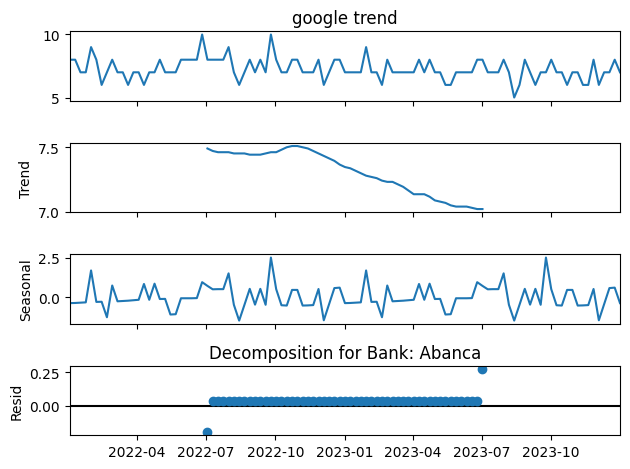

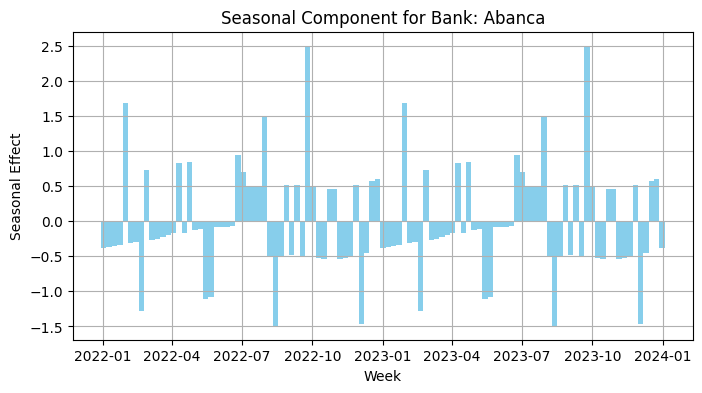

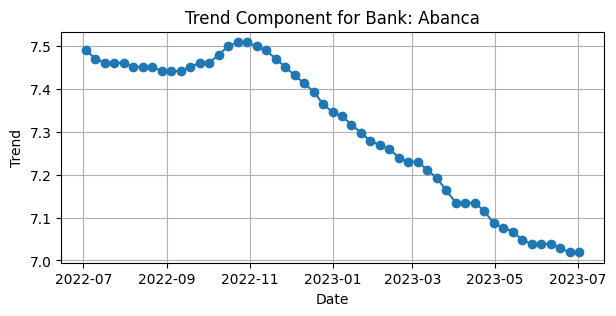

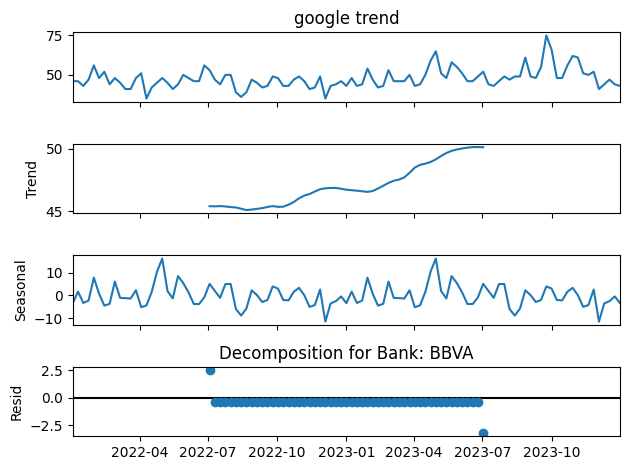

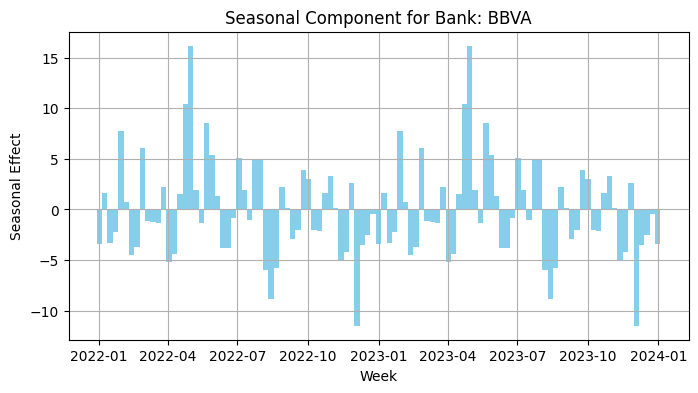

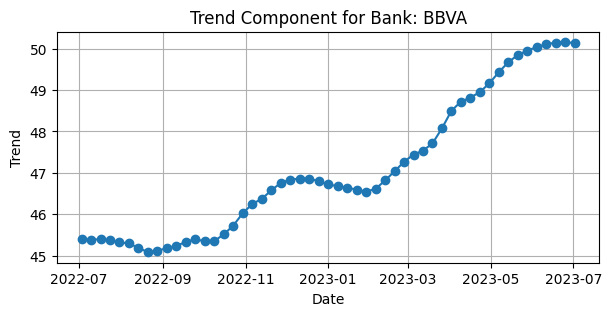

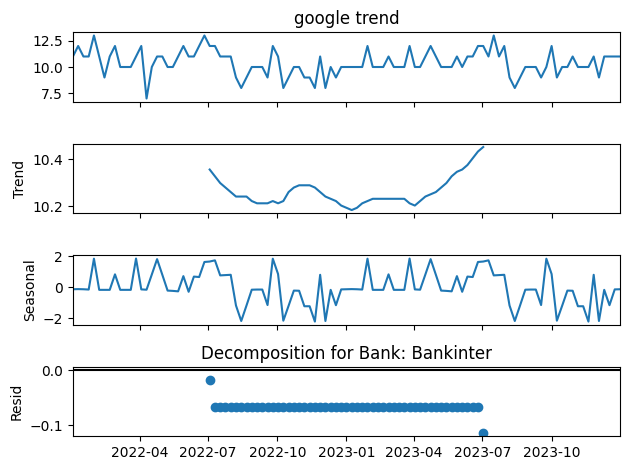

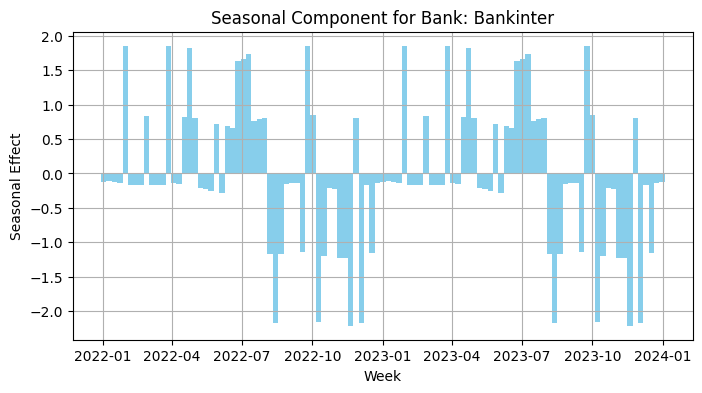

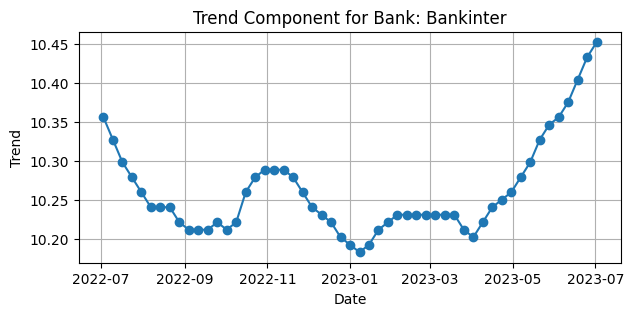

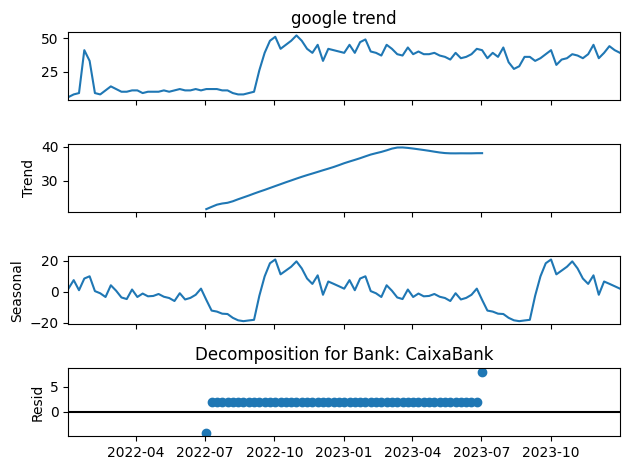

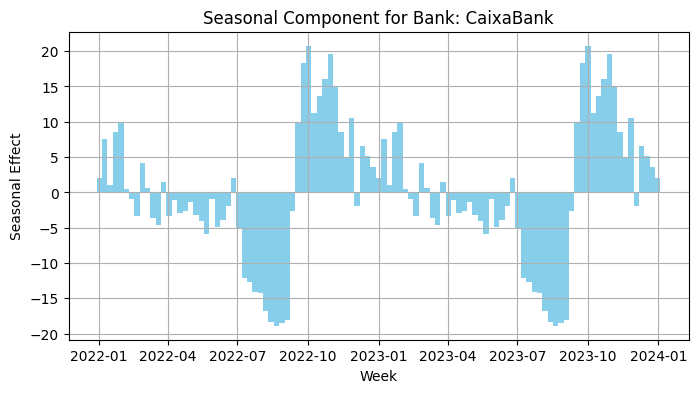

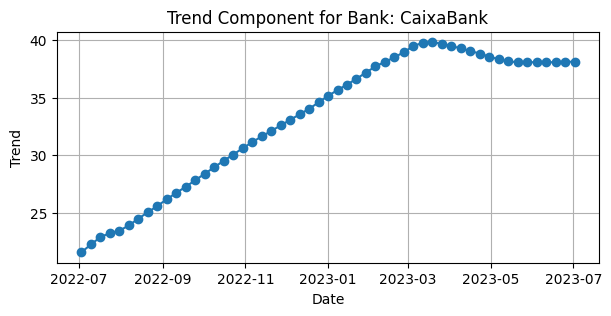

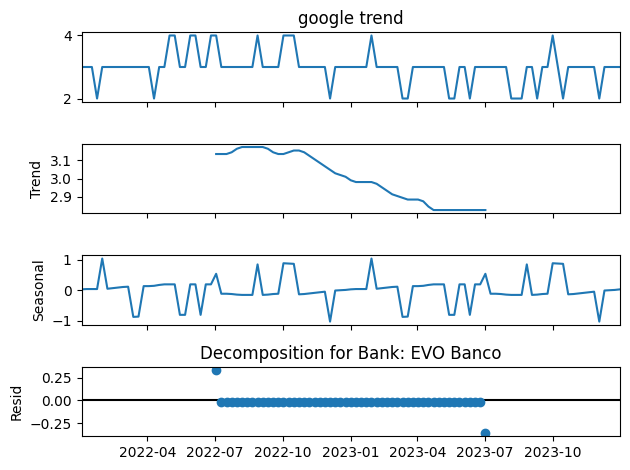

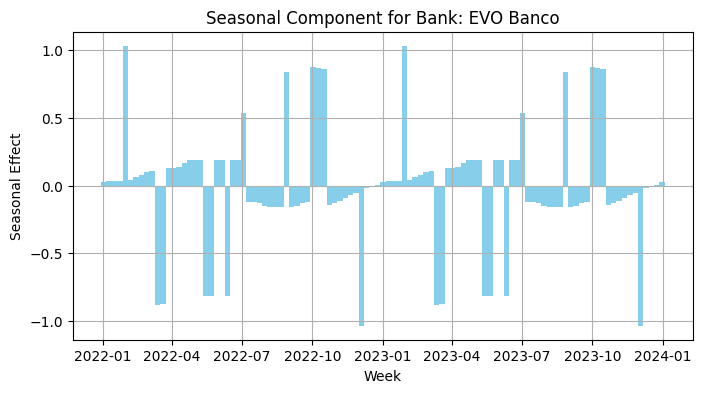

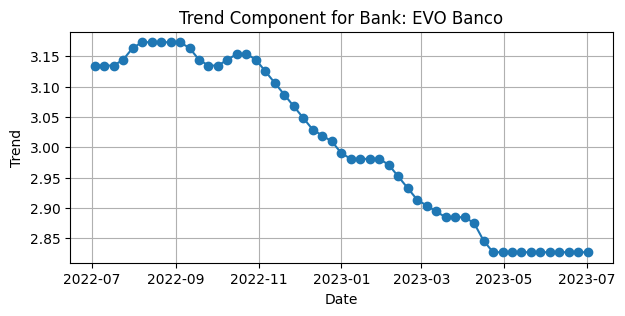

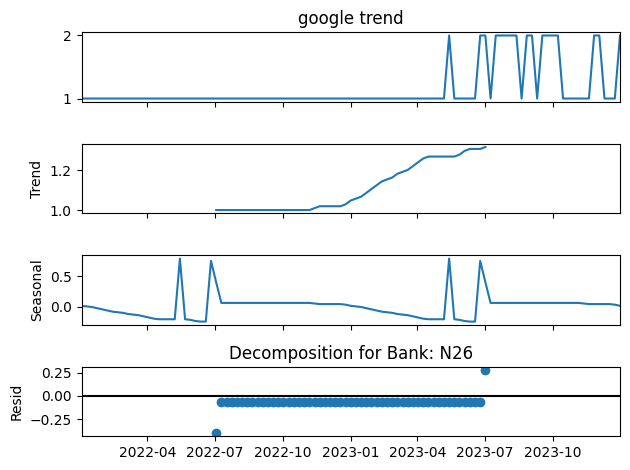

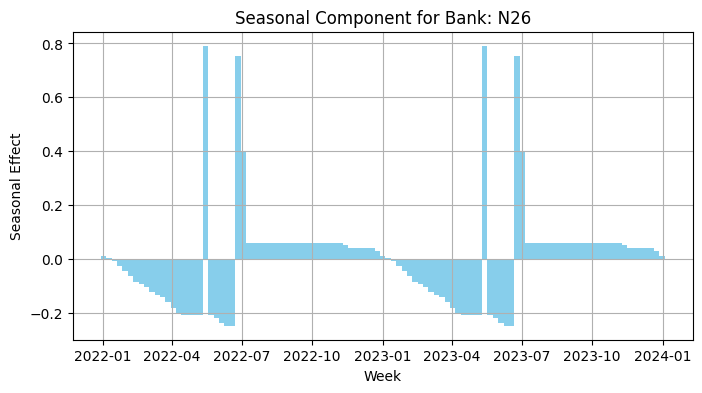

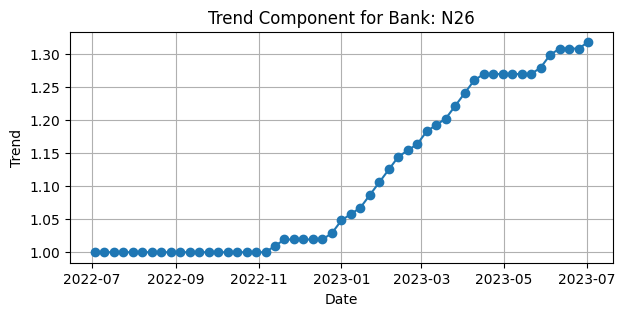

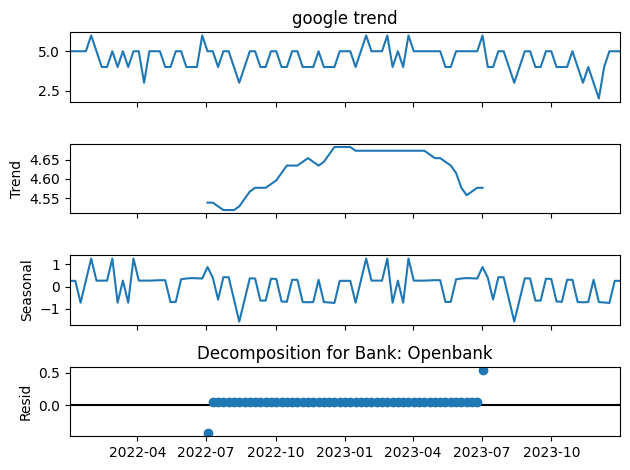

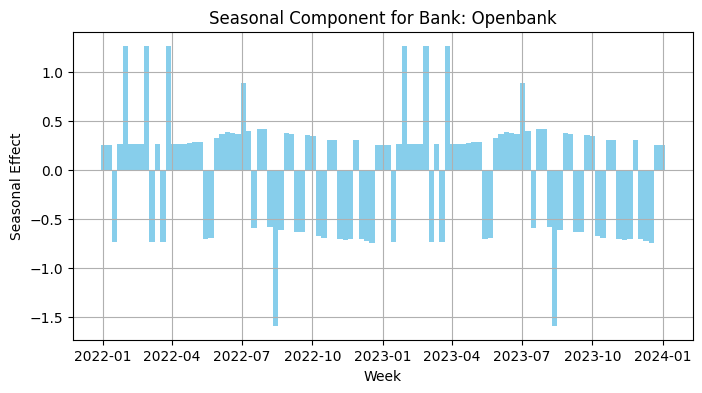

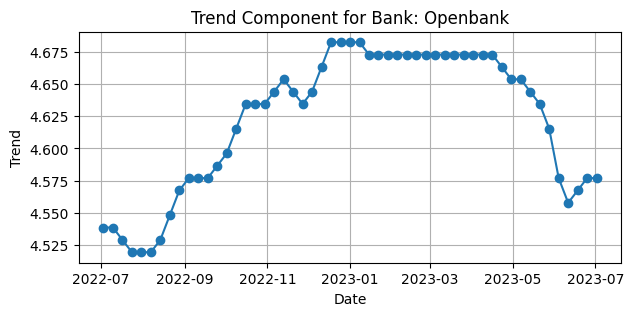

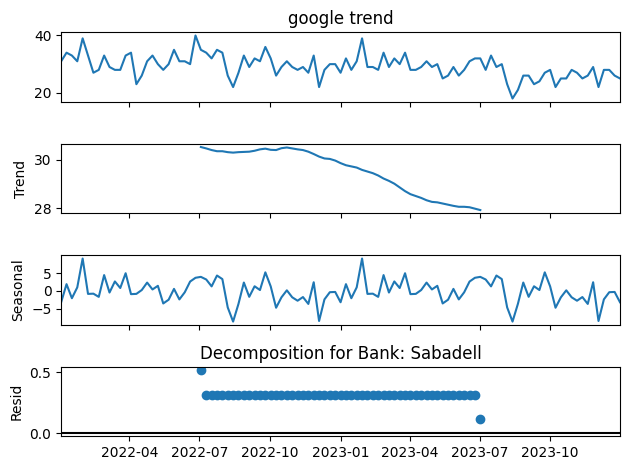

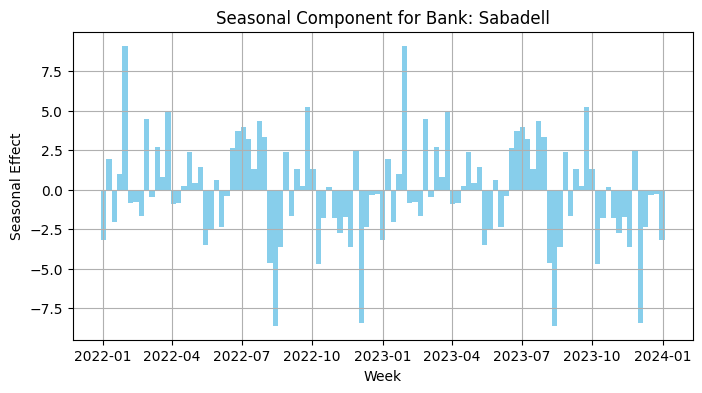

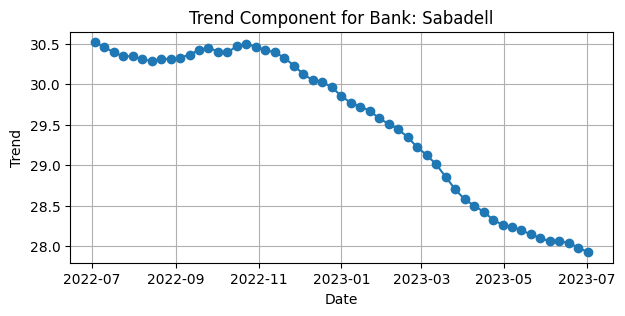

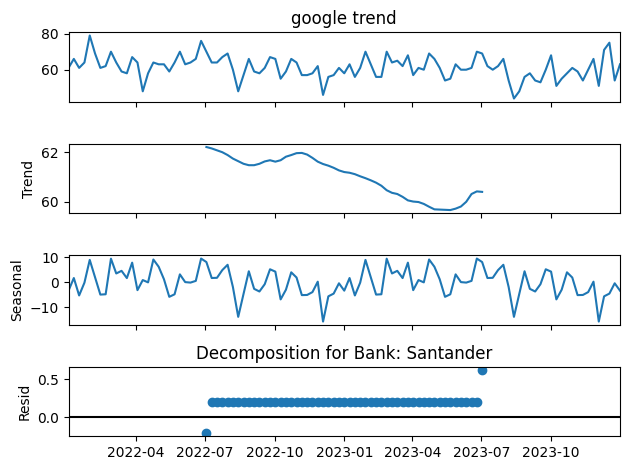

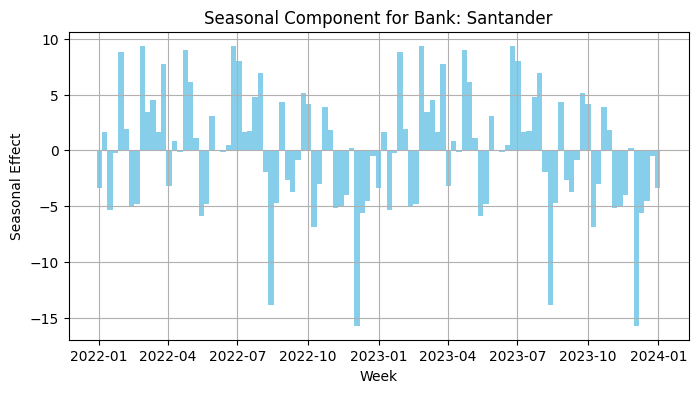

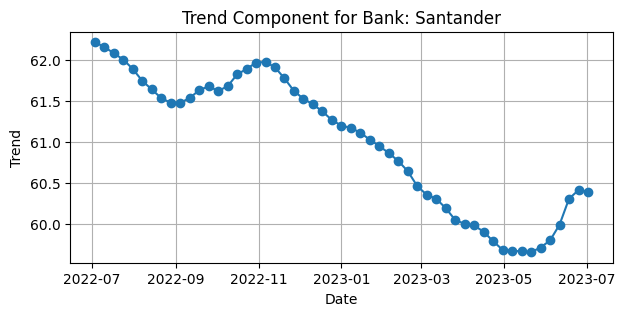

C:\Users\wuhangze\AppData\Local\Temp\ipykernel_21388\3913554620.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = date_range_df.groupby('bank name').apply(


In [47]:
results = date_range_df.groupby('bank name').apply(
    lambda group: decompose_and_analyze_seasonality(group, 'google trend', 'additive')
)

In [48]:

# Extract seasonal and trend components for further analysis if needed
seasonal_effects = results.apply(lambda x: x[0])
trend_effects = results.apply(lambda x: x[1])

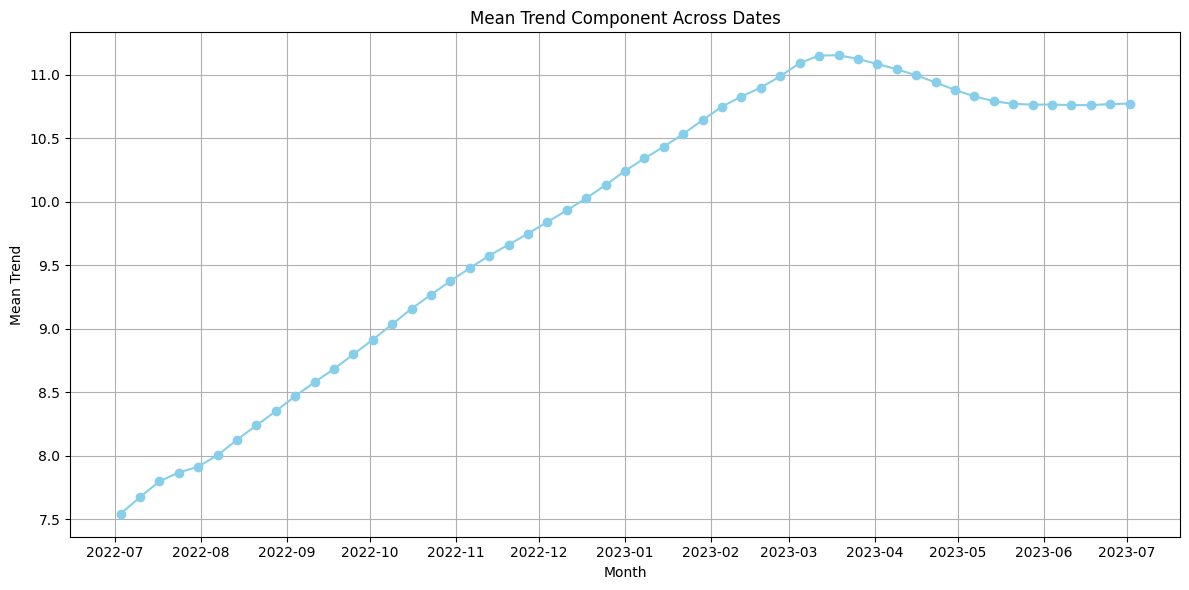

In [49]:
# Transpose the DataFrame to have dates as the index
trends_effect = trend_effects.T
trends_effect.index = pd.to_datetime(trends_effect.index)

# Calculate the mean trend across all banks for each date, ignoring NaNs
excluded_banks = ['Santander', 'Sabadell', 'BBVA', 'Bankinter']
filtered_trends_effect = trends_effect.drop(columns=excluded_banks)

mean_trend = filtered_trends_effect.mean(axis=1, skipna=True)

# Drop rows with NaN values in mean_trend
mean_trend = mean_trend.dropna()

# Plot the mean trend component
plt.figure(figsize=(12, 6))
plt.plot(mean_trend.index, mean_trend.values, marker='o', color='skyblue')

# Format x-axis to show month and year, only the first day of each month
months = mean_trend.index.to_period('M').unique().to_timestamp()

# Show only the first day of each month on the x-axis
plt.xticks(months, months.strftime('%Y-%m'))

# Set up the plot details
plt.title('Mean Trend Component Across Dates')
plt.xlabel('Month')
plt.ylabel('Mean Trend')
plt.grid(True)

# Adjust layout to ensure everything fits without overlapping
plt.tight_layout()
plt.show()

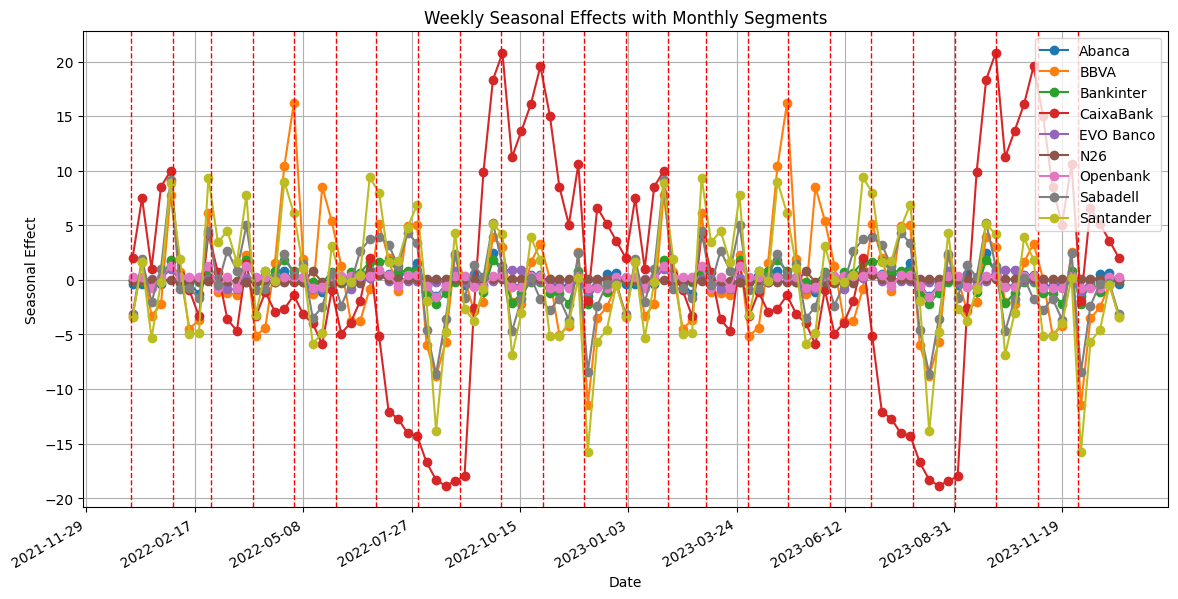

In [50]:
seasonal_effects = seasonal_effects.T
seasonal_effects.index = pd.to_datetime(seasonal_effects.index)

# Plotting
plt.figure(figsize=(14, 7))  # Adjusting figure size for clarity

# Plot the seasonal effects for each bank
for bank in seasonal_effects.columns:
    plt.plot(seasonal_effects.index, seasonal_effects[bank], marker='o', label=bank)

# Identify the start of each month
month_starts = seasonal_effects.index.to_period('M').drop_duplicates().to_timestamp()

# Adding vertical lines to indicate the start of each month
for month_start in month_starts:
    plt.axvline(x=month_start, color='red', linestyle='--', linewidth=1)

# Setting up the x-axis to show dates
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(12))
plt.gcf().autofmt_xdate()

# Setting labels and title
plt.title('Weekly Seasonal Effects with Monthly Segments')
plt.xlabel('Date')
plt.ylabel('Seasonal Effect')
plt.legend(loc='best')
plt.grid(True)

# Show the plot
plt.show()

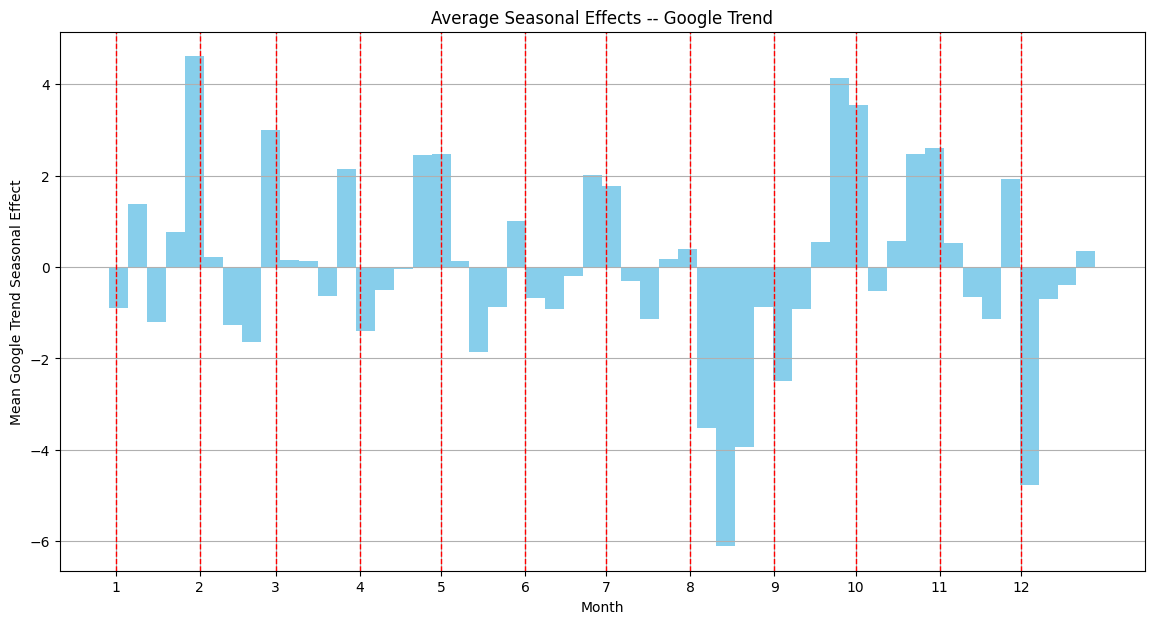

In [51]:
# Calculate the mean seasonal effects across all banks
excluded_banks =[]# ['Santander', 'Sabadell', 'BBVA', ]#'Bankinter'
filtered_seasonal_effects = seasonal_effects.drop(columns=excluded_banks)

mean_seasonal_effects = filtered_seasonal_effects.mean(axis=1)

# Filter the data to only include January 2022 to December 2022
filtered_mean_seasonal_effects = mean_seasonal_effects['2022-01-01':'2022-12-31']

# Plotting
plt.figure(figsize=(14, 7))  # Adjusting figure size for clarity
plt.bar(filtered_mean_seasonal_effects.index, filtered_mean_seasonal_effects.values, color='skyblue', width=7)  # Bar width set to 7 days

# Identify the start of each month within the filtered period
month_starts = filtered_mean_seasonal_effects.index.to_period('M').drop_duplicates().to_timestamp()

# Adding vertical lines to indicate the start of each month
for month_start in month_starts:
    plt.axvline(x=month_start, color='red', linestyle='--', linewidth=1)

# Setting up the x-axis to show month numbers from 1 to 12
plt.xticks(month_starts, labels=np.arange(1, 13))

# Setting labels and title
plt.title('Average Seasonal Effects -- Google Trend')
plt.xlabel('Month')
plt.ylabel('Mean Google Trend Seasonal Effect')
plt.grid(True)

# Show the plot
plt.show()


In [52]:
filtered_mean_seasonal_effects 

Date
2022-01-02   -0.907216
2022-01-09    1.389793
2022-01-16   -1.202087
2022-01-23    0.760519
2022-01-30    4.612015
2022-02-06    0.228468
2022-02-13   -1.264053
2022-02-20   -1.636917
2022-02-27    2.989152
2022-03-06    0.156887
2022-03-13    0.131246
2022-03-20   -0.636917
2022-03-27    2.151545
2022-04-03   -1.408284
2022-04-10   -0.512985
2022-04-17   -0.037558
2022-04-24    2.445348
2022-05-01    2.473126
2022-05-08    0.138725
2022-05-15   -1.862344
2022-05-22   -0.866617
2022-05-29    1.010519
2022-06-05   -0.672173
2022-06-12   -0.923241
2022-06-19   -0.186062
2022-06-26    2.022272
2022-07-03    1.781887
2022-07-10   -0.298241
2022-07-17   -1.128369
2022-07-24    0.185733
2022-07-31    0.402613
2022-08-07   -3.510848
2022-08-14   -6.108070
2022-08-21   -3.927515
2022-08-28   -0.875164
2022-09-04   -2.503369
2022-09-11   -0.914694
2022-09-18    0.555391
2022-09-25    4.140861
2022-10-02    3.540434
2022-10-09   -0.534352
2022-10-16    0.572485
2022-10-23    2.475263
2022-1

In [53]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import pandas as pd

def decompose_and_analyze_seasonality(group, target_column = 'Rank', model_type = 'additive'):
    # Check for sufficient data points
    if group[target_column].dropna().shape[0] < 2:
        print(f"Not enough data to decompose for {group.name}")
        return group

    # Handle missing values appropriately
    #group[target_column] = group[target_column].fillna(method='ffill').fillna(method='bfill')
    
    
    # Ensure data frequency is set correctly to monthly
    if not pd.infer_freq(group.index):
        group = group.asfreq('M')

    # Perform seasonal decomposition
    try:
        # period of 12 for monthly data (yearly seasonality)
        result = seasonal_decompose(group[target_column], model=model_type, period=12)
        result.plot()
        plt.title(f"Decomposition for Bank: {group.name[0]}, Category: {group.name[1]}")
        plt.tight_layout()
        plt.show()
        
        analyze_seasonal_component(result.seasonal, group.name)
        #analyze_error_component(result.resid, group.name)

        return result.seasonal
    except ValueError as e:
        print(f"Decomposition failed for {group.name} with error: {e}")


def analyze_seasonal_component(seasonal_series, name):
    # Group by month to see the average seasonal effect per month
    monthly_seasonal_effect = seasonal_series.groupby(seasonal_series.index.month).mean()
    monthly_seasonal_effect.plot(kind='bar')
    plt.title(f"Average Monthly Seasonal Effects for {name[0]}, {name[1]}")
    plt.xlabel('Month')
    plt.ylabel('Seasonal Effect')
    plt.show()
    
def analyze_error_component(residuals, name):
    if residuals.isnull().any():
        residuals = residuals.dropna()  # Ensure there are no NaNs

    # Plotting the ACF and PACF
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
    
    plot_acf(residuals, lags=40, ax=ax1)
    ax1.set_title(f'Autocorrelation Function for {name[0]}, {name[1]}')

    plot_pacf(residuals, lags=40, ax=ax2)
    ax2.set_title(f'Partial Autocorrelation Function for {name[0]}, {name[1]}')
    
    plt.tight_layout()
    plt.show()

In [54]:
google_df = df.copy()
google_df['Date'] = pd.to_datetime(google_df['Date'])

# Set 'Date' as index
google_df.set_index('Date', inplace=True)

google_df.sort_index(inplace=True)

# Filter for dates before 2022-01-01
filtered_df = google_df.loc['2021-1-01':]

google_df = filtered_df

# Resample to monthly frequency and aggregate data
monthly_google_df = google_df.resample('M').mean()  # Use sum, mean, or other aggregation function

# Reset index to have 'Month' as a column
monthly_google_df.reset_index(inplace=True)

monthly_google_df= monthly_google_df.reset_index(drop=True)
# Melting the DataFrame
long_monthly_google_df = monthly_google_df.melt(id_vars=['Date'], var_name='bank name', value_name='google trend')

long_monthly_google_df['Date'] = pd.to_datetime(long_monthly_google_df['Date'])
long_monthly_google_df.set_index('Date', inplace=True)

long_monthly_google_df.head(3)

C:\Users\wuhangze\AppData\Local\Temp\ipykernel_21388\1146286630.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_google_df = google_df.resample('M').mean()  # Use sum, mean, or other aggregation function


,bank name,google trend
Date,,
2021-12-31,Abanca,7.75
2022-01-31,Abanca,7.80
2022-02-28,Abanca,7.25


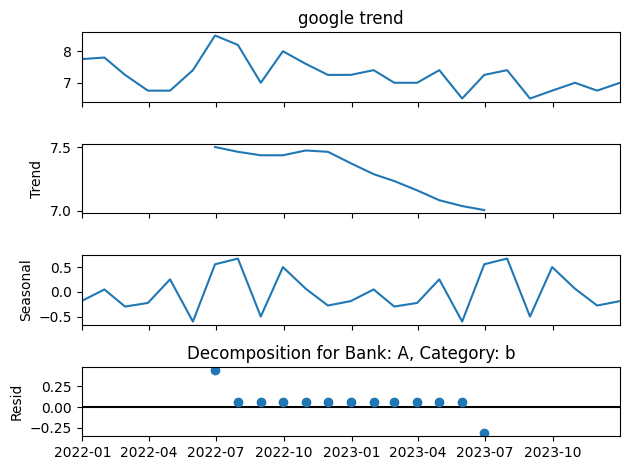

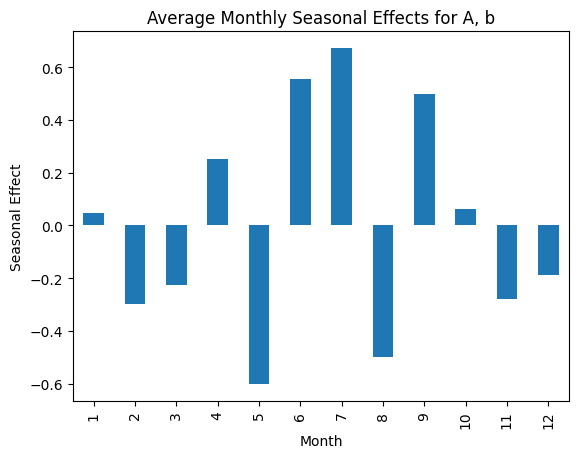

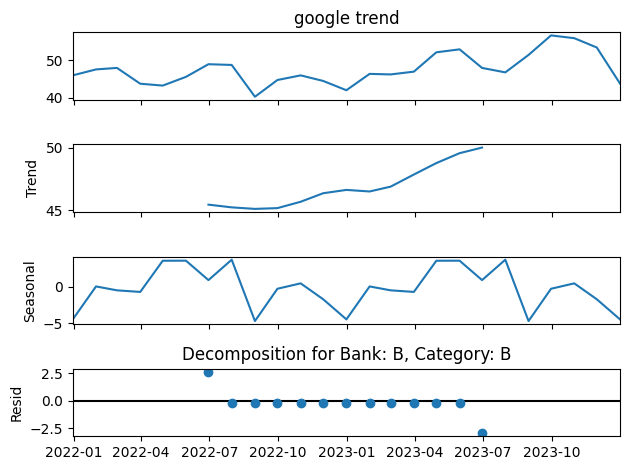

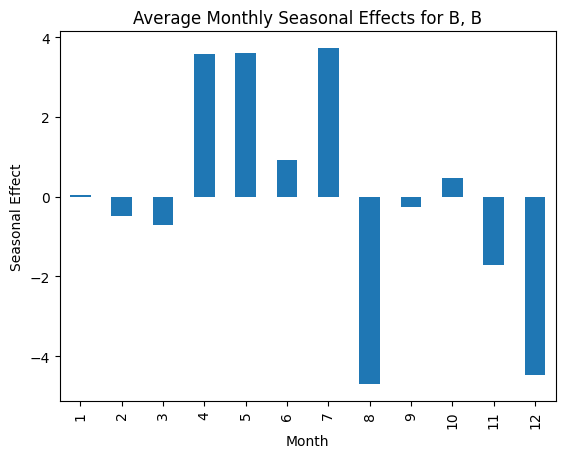

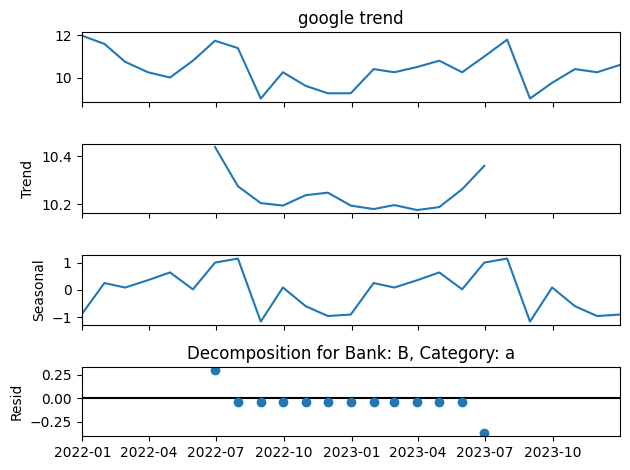

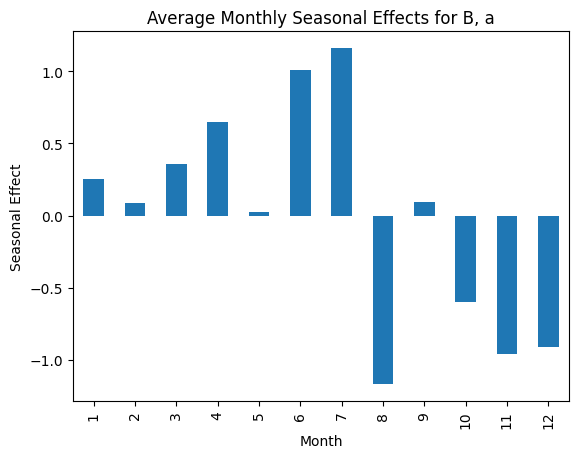

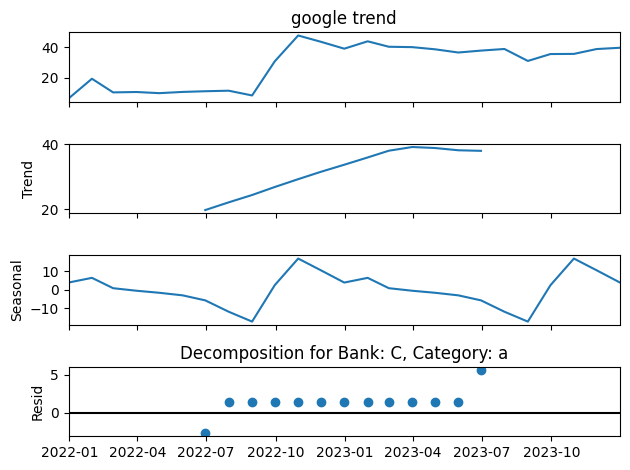

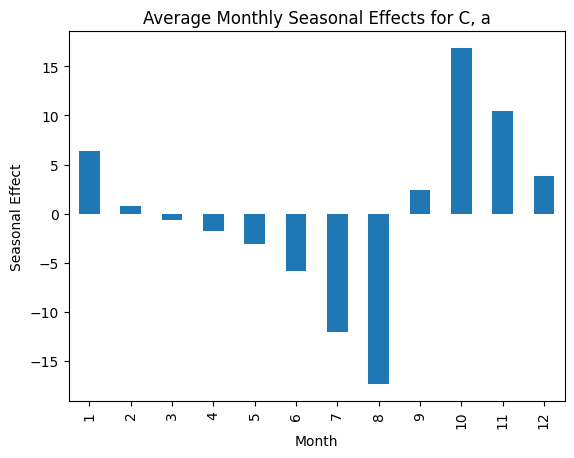

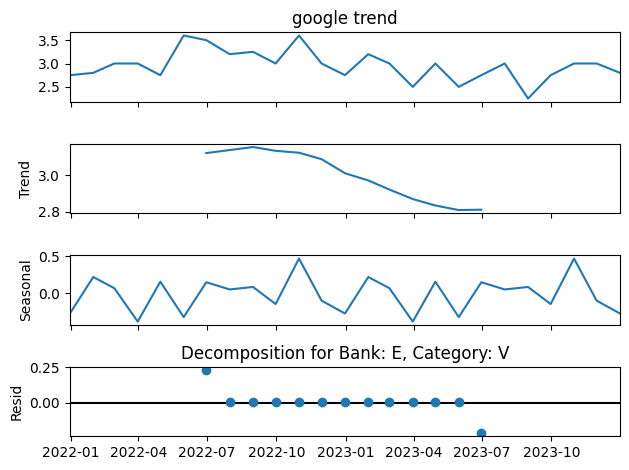

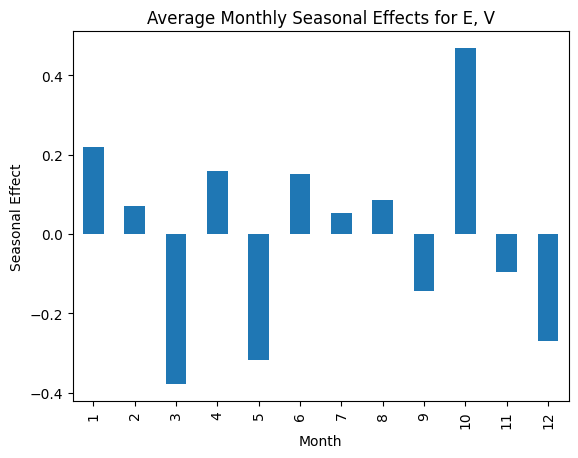

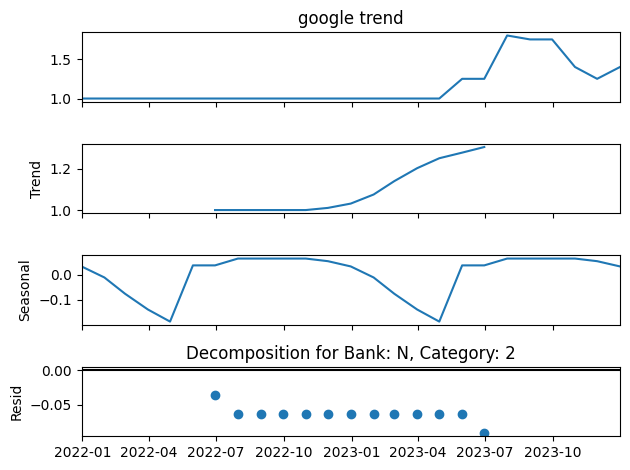

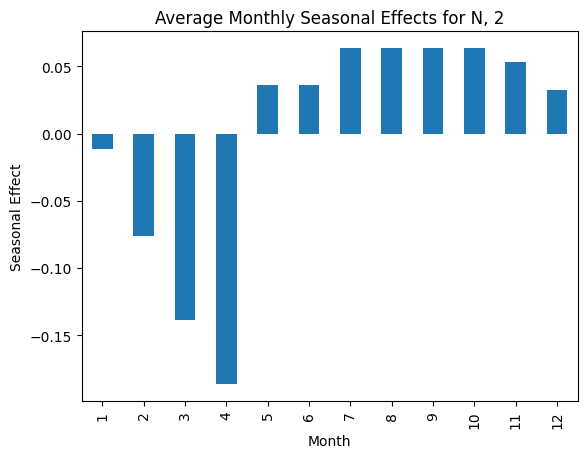

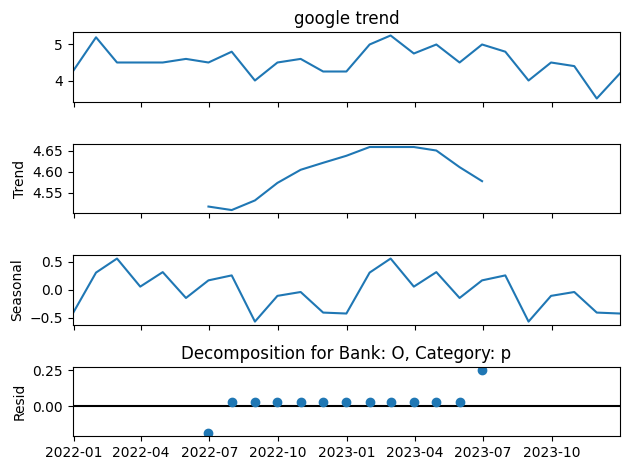

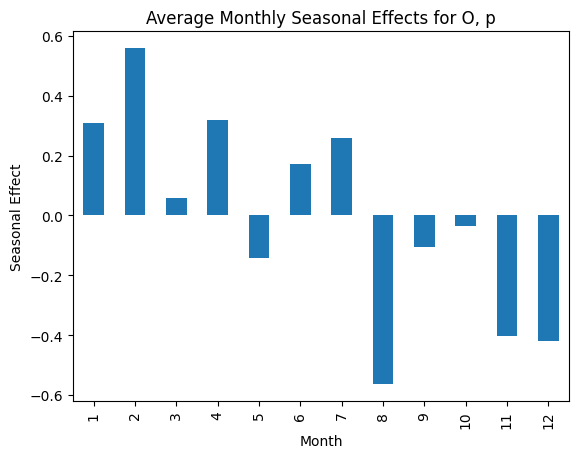

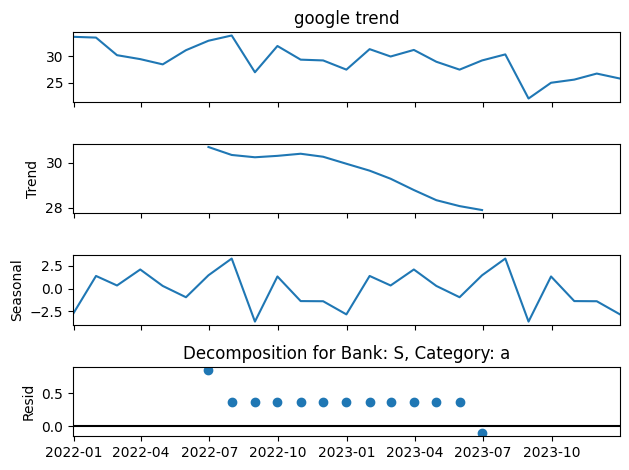

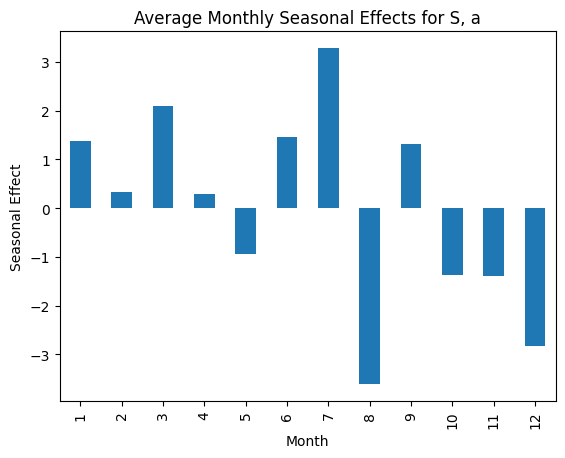

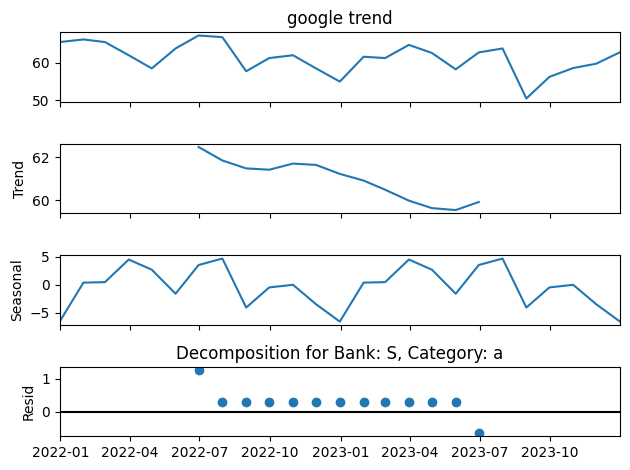

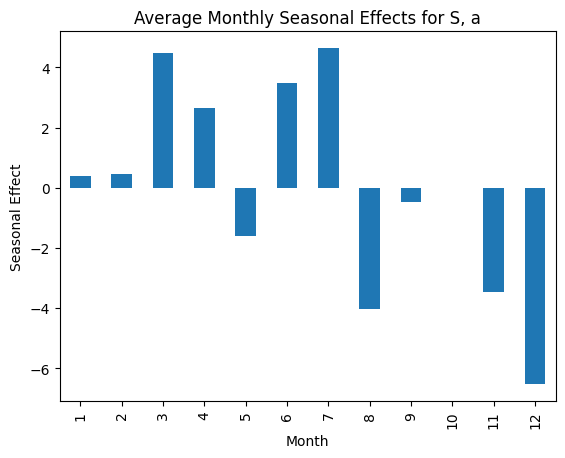

C:\Users\wuhangze\AppData\Local\Temp\ipykernel_21388\4098118263.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  seasonal_effects = long_monthly_google_df.groupby(['bank name']).apply(


In [55]:
seasonal_effects = long_monthly_google_df.groupby(['bank name']).apply(
    lambda group: decompose_and_analyze_seasonality(group, 'google trend', 'additive'))

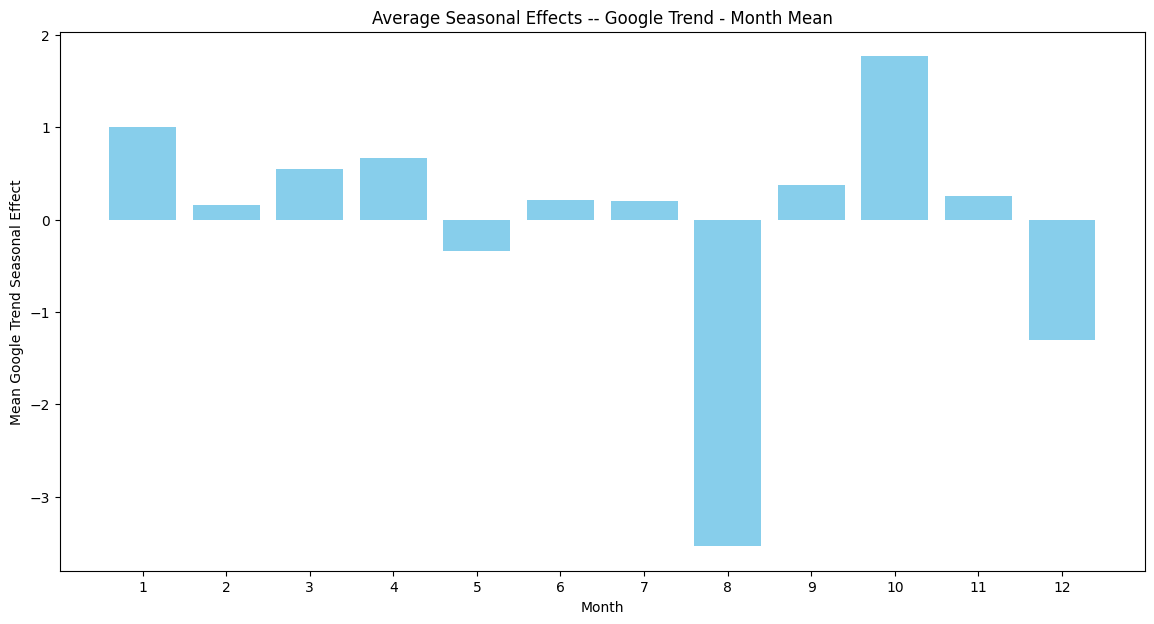

In [56]:
import matplotlib.pyplot as plt
import numpy as np

seasonal_effects = seasonal_effects.dropna()
monthly_mean_seasonal_effects = seasonal_effects.mean(axis=0)

# Limit to the first 12 months
monthly_mean_seasonal_effects = monthly_mean_seasonal_effects[1:13]

# Plotting
plt.figure(figsize=(14, 7))  # Adjusting figure size for clarity
plt.bar(range(1, 13), monthly_mean_seasonal_effects.values, color='skyblue', width=0.8)

# Setting up the x-axis to show month numbers from 1 to 12
plt.xticks(np.arange(1, 13, step=1))

# Setting labels and title
plt.title('Average Seasonal Effects -- Google Trend - Month Mean')
plt.xlabel('Month')
plt.ylabel('Mean Google Trend Seasonal Effect')

# Show the plot
plt.show()


In [20]:
google_df = df.copy()
google_df['Date'] = pd.to_datetime(google_df['Date'])

# Set 'Date' as index
google_df.set_index('Date', inplace=True)

google_df.sort_index(inplace=True)

# Filter for dates before 2022-01-01
filtered_df = google_df.loc['2021-1-01':]

google_df = filtered_df

# Resample to monthly frequency and aggregate data
monthly_google_df = google_df.resample('M').sum()  # Use sum, mean, or other aggregation function

# Reset index to have 'Month' as a column
monthly_google_df.reset_index(inplace=True)

monthly_google_df= monthly_google_df.reset_index(drop=True)
# Melting the DataFrame
long_monthly_google_df = monthly_google_df.melt(id_vars=['Date'], var_name='bank name', value_name='google trend')

long_monthly_google_df['Date'] = pd.to_datetime(long_monthly_google_df['Date'])
long_monthly_google_df.set_index('Date', inplace=True)

long_monthly_google_df.head(3)

C:\Users\wuhangze\AppData\Local\Temp\ipykernel_27604\1389818101.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_google_df = google_df.resample('M').sum()  # Use sum, mean, or other aggregation function


,bank name,google trend
Date,,
2021-12-31,Abanca,31
2022-01-31,Abanca,39
2022-02-28,Abanca,29


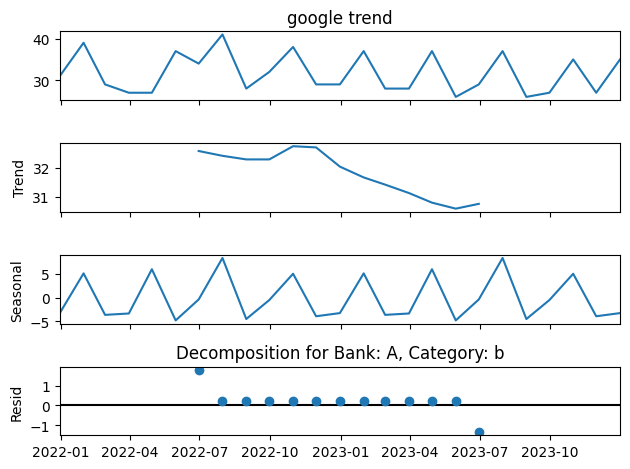

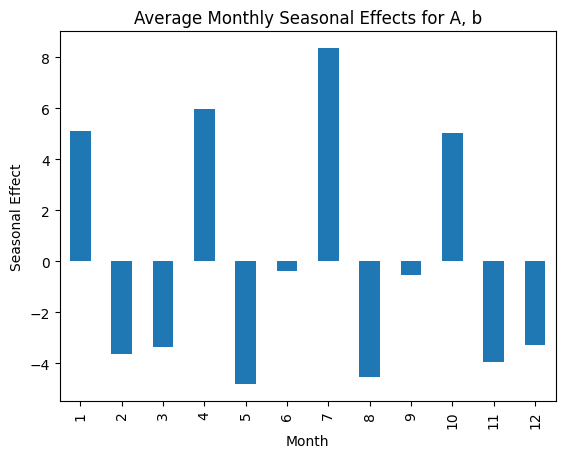

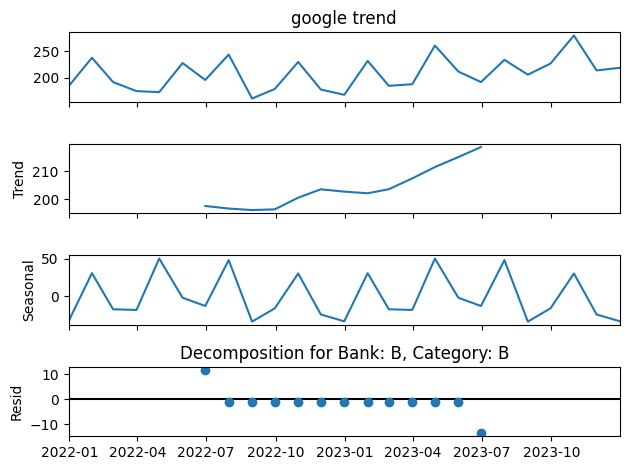

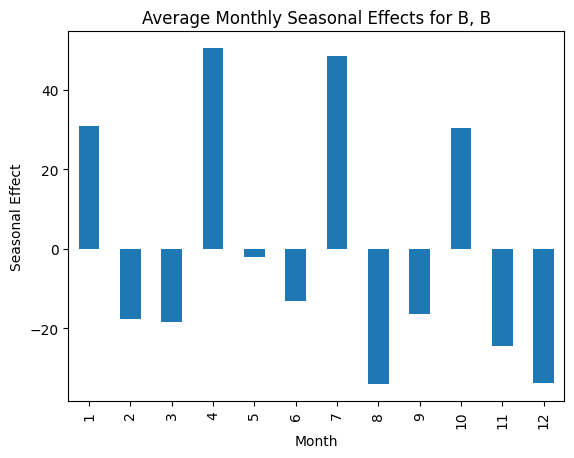

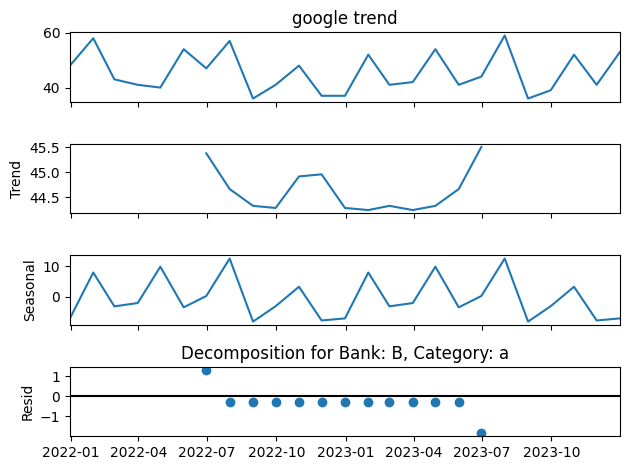

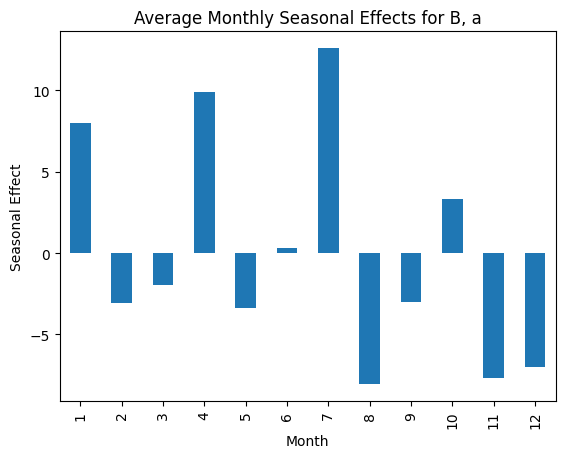

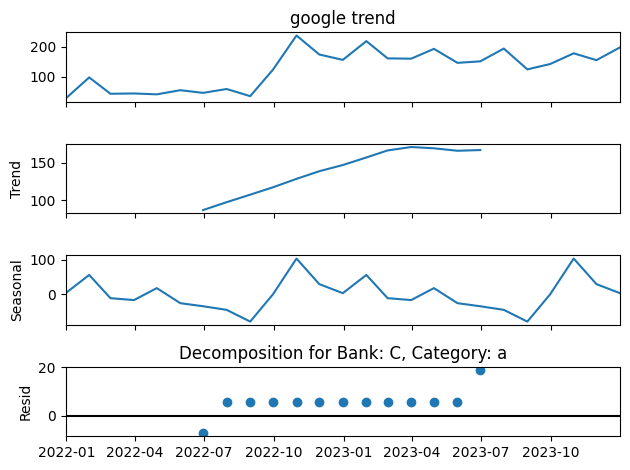

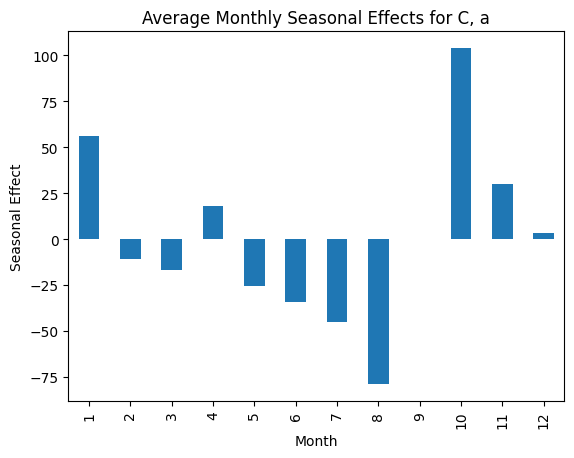

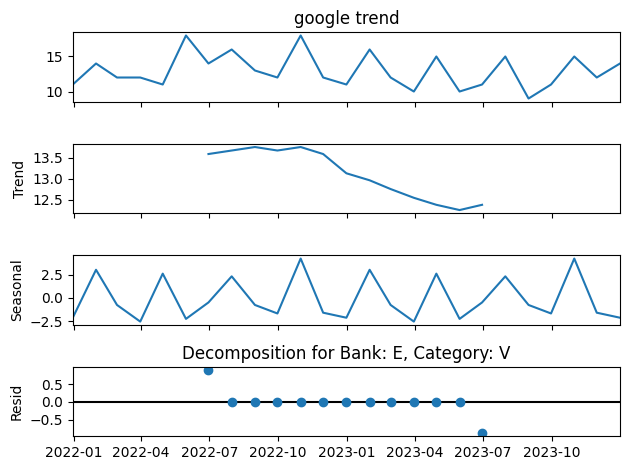

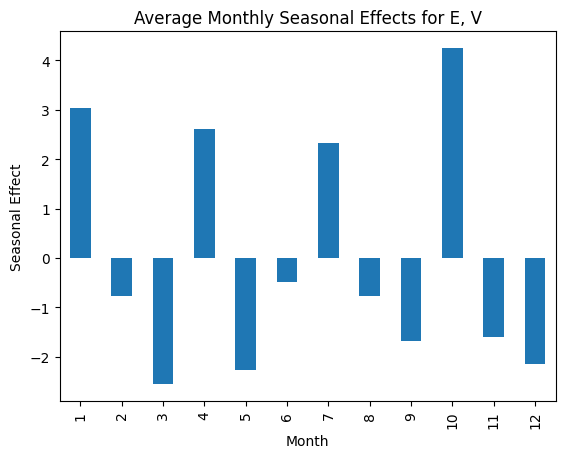

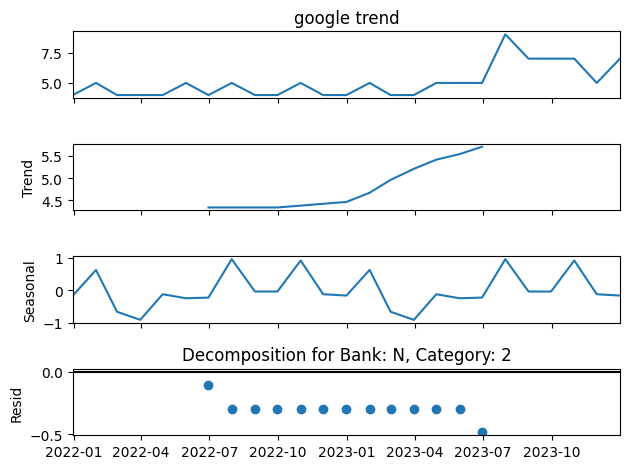

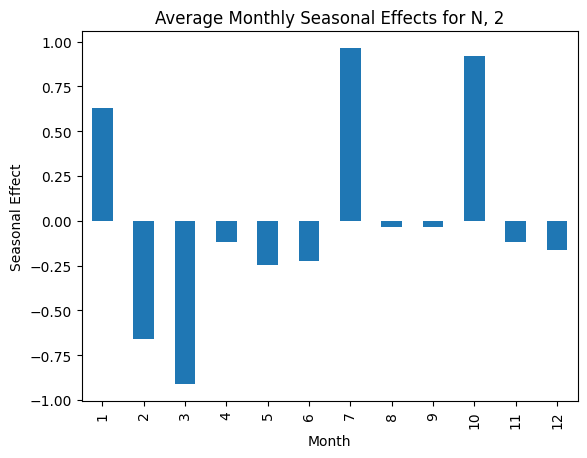

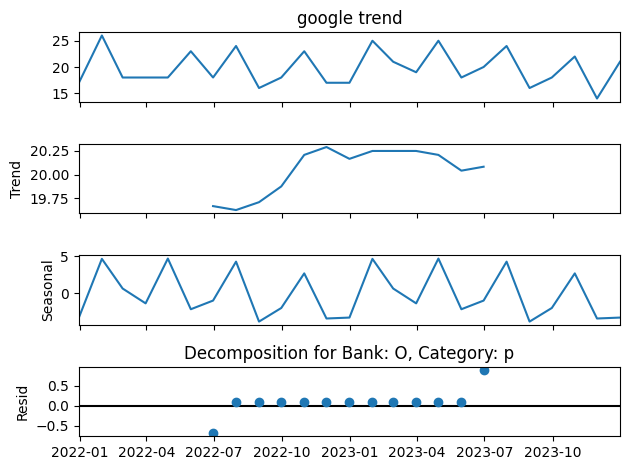

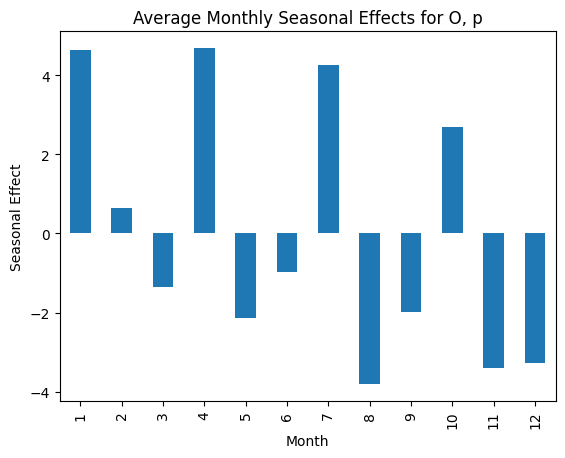

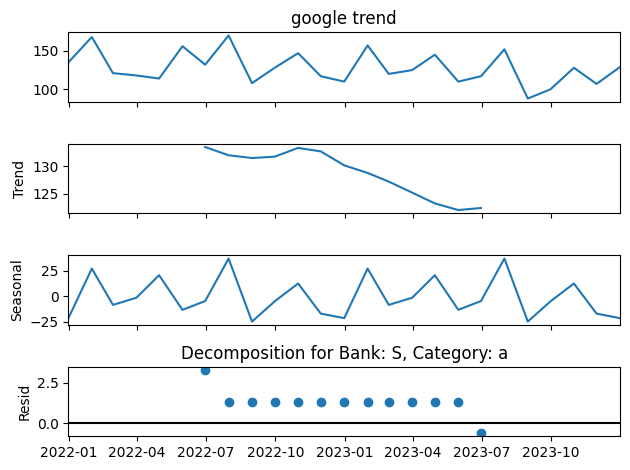

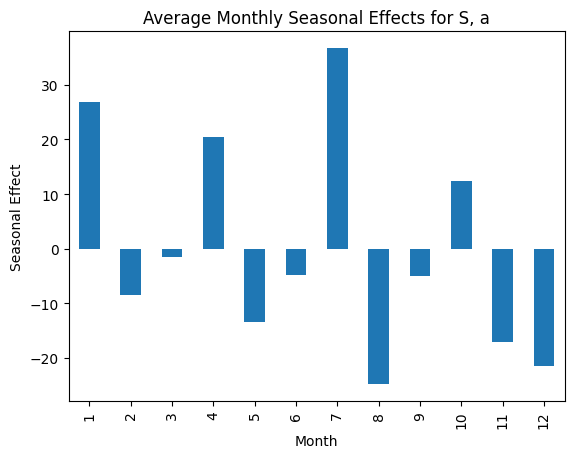

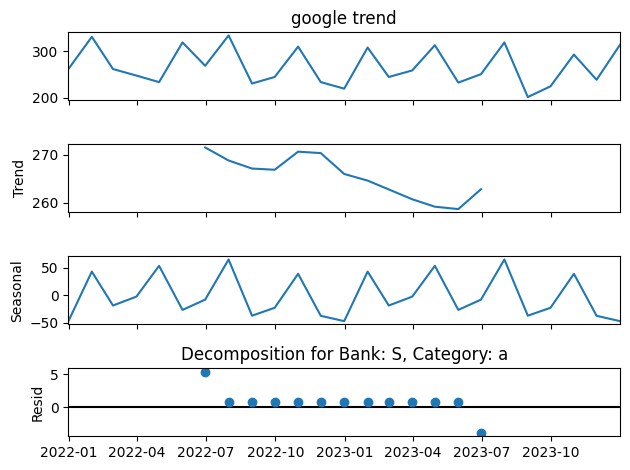

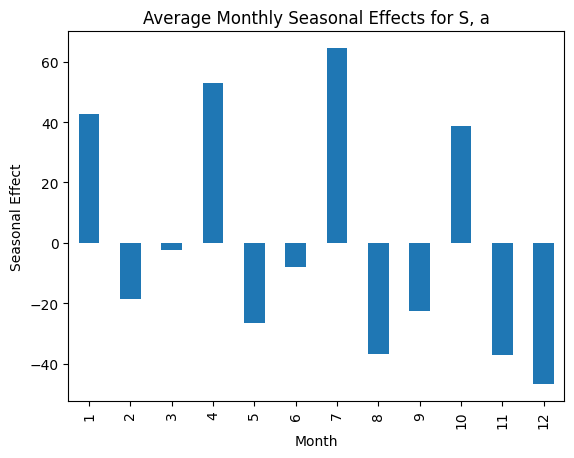

C:\Users\wuhangze\AppData\Local\Temp\ipykernel_21388\4098118263.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  seasonal_effects = long_monthly_google_df.groupby(['bank name']).apply(


In [58]:
seasonal_effects = long_monthly_google_df.groupby(['bank name']).apply(
    lambda group: decompose_and_analyze_seasonality(group, 'google trend', 'additive'))

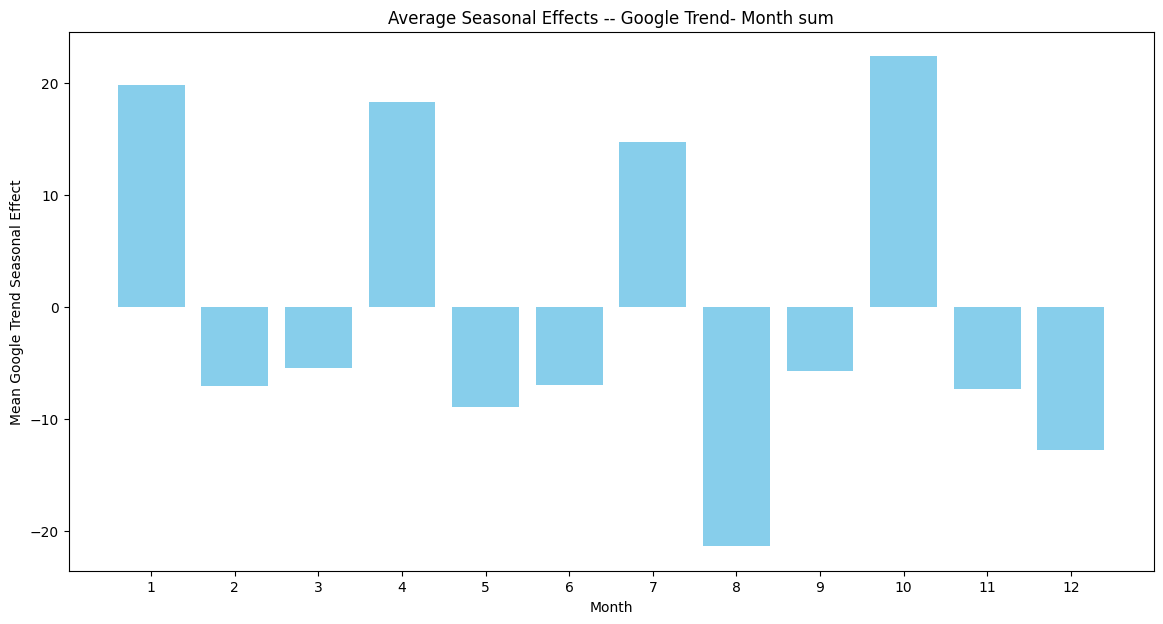

In [59]:
import matplotlib.pyplot as plt
import numpy as np

seasonal_effects = seasonal_effects.dropna()
monthly_mean_seasonal_effects = seasonal_effects.mean(axis=0)

# Limit to the first 12 months
monthly_mean_seasonal_effects = monthly_mean_seasonal_effects[1:13]

# Plotting
plt.figure(figsize=(14, 7))  # Adjusting figure size for clarity
plt.bar(range(1, 13), monthly_mean_seasonal_effects.values, color='skyblue', width=0.8)

# Setting up the x-axis to show month numbers from 1 to 12
plt.xticks(np.arange(1, 13, step=1))

# Setting labels and title
plt.title('Average Seasonal Effects -- Google Trend- Month sum')
plt.xlabel('Month')
plt.ylabel('Mean Google Trend Seasonal Effect')

# Show the plot
plt.show()
